# Show the disaggregator overview

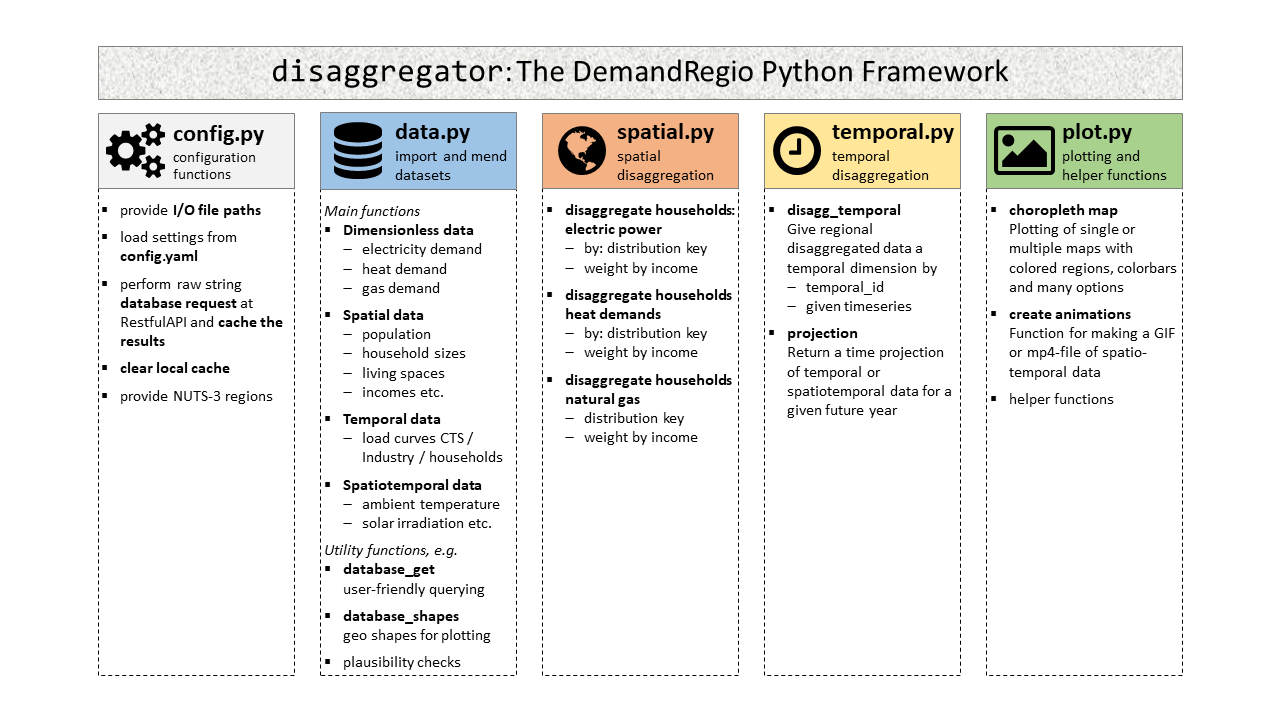

In [1]:
from IPython.display import Image
pic = Image(filename=('./img/overview.png'))
pic

# Spatial disaggregation with `spatial.py`

Now, as we've gathered a spatial feeling for the relevant input data in the first notebook, let's take a look at the spatial disaggregation abilities.

In [2]:
import pandas as pd
from disaggregator import config, data, spatial, plot

## Electric Power Consumption in [GWh/a]

The disaggregation method for the electric power consumption of private households is `spatial.disagg_households_power()` and requires at least one argument:

1. ``by`` is the distribution key and must be one of ``['population', 'households']``.  

    Using ``population`` invokes a *top-down*-method, i.e. the overall electricity consumption of entire Germany is being spread by distribution keys based on the population to calculate the consumption per region.  
    Using ``households`` invokes a *bottom-up*-method, i.e. the average electricity consumptions known for each household size are used for calculating the consumption per region.

Additionally, an income adjustment can be performed, through the switch ``weight_by_income=True``.

Let's start with ``population``:

In [3]:
ec_pop = spatial.disagg_households_power(by='population', weight_by_income=False)
ec_pop.head()

nuts3
DE111   1,001.919
DE112     612.457
DE113     841.913
DE114     405.994
DE115     857.891
Name: value, dtype: float64

... and continue with ``households``:

In [4]:
ec_hh = spatial.disagg_households_power(by='households', weight_by_income=False)
ec_hh.head()

hh_size,1,2,3,4,5,6
nuts3,,,,,,
DE111,306.976,297.056,158.990,137.590,56.357,27.767
DE112,121.320,172.360,106.016,110.908,42.361,17.855
DE113,181.519,246.359,144.365,146.807,52.937,22.088
DE114,77.681,115.019,71.918,73.061,27.868,11.957
DE115,181.499,258.664,142.738,149.889,53.577,22.485


So, do these two fundamentally different methods lead to comparable results? Let's check, by summing the consumptions of all six household types per region:

In [5]:
ec_hh.head().sum(axis=1)

nuts3
DE111   984.736
DE112   570.821
DE113   794.074
DE114   377.504
DE115   808.852
dtype: float64

Okay, that seems comparable.  
Let's further check the results by plotting these side by side on *one* map. We can achieve this, by merging the results into one new ``pd.DataFrame`` :

In [6]:
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1)], keys=['population', 'households'], axis=1, join='inner')
ec_combined.head()

,population,households
nuts3,,
DE111,"1,001.919",984.736
DE112,612.457,570.821
DE113,841.913,794.074
DE114,405.994,377.504
DE115,857.891,808.852


... and plot:

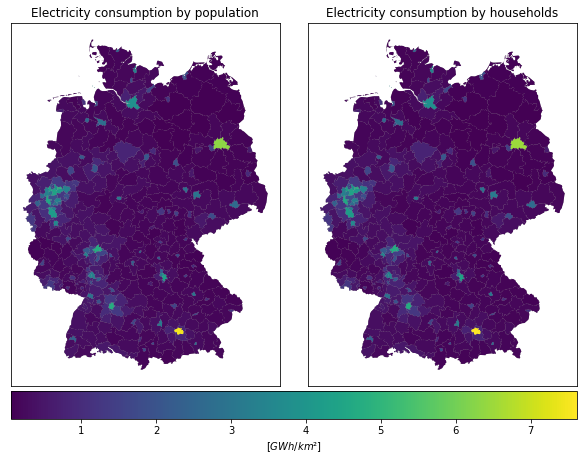

In [7]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh', axtitle='Electricity consumption by', add_percentages=False)

Now let's weight the consumptions by the available income:

In [8]:
ec_pop_ic = spatial.disagg_households_power(by='population', weight_by_income=True)
ec_hh_ic = spatial.disagg_households_power(by='households', weight_by_income=True)
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1), ec_pop_ic, ec_hh_ic.sum(axis=1)],
                        keys=['population', 'households', 'population (weighted)', 'households (weighted)'],
                        axis=1, join='inner')

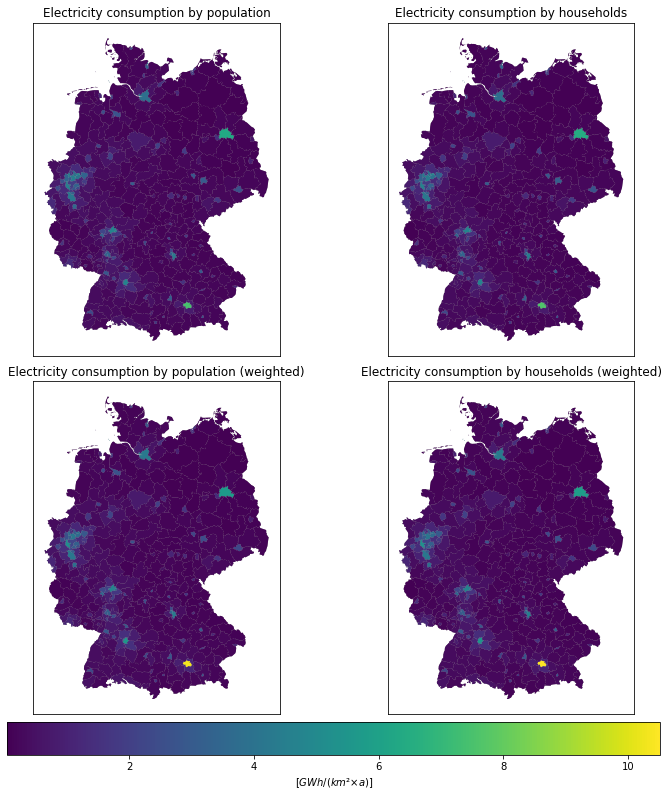

In [9]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh/a', axtitle='Electricity consumption by',
                              add_percentages=False, figsize=(10,12))

Now save this figure e.g. as PDF file:

In [10]:
from disaggregator.config import _data_out
fig.savefig(_data_out('disagg_households_power.pdf'), bbox_inches='tight')

## Heat consumption in [MWh/a]

The heating demands of private households are threefold:
1. cooking (=process heat)
2. warm water
3. space heating

The first two ones depend mainly on the **household size**, whereas the latter depends mainly on the **size of the building**. However, centralized space heating systems are very often also used as boilers for the hot water supply.

In [11]:
df_heat = spatial.disagg_households_heat(by='households')
df_heat.head()

Application           Cooking                                             \
PersonsInHousehold      1.000      2.000      3.000      4.000     5.000   
nuts3                                                                      
DE111              27,268.362 36,737.712 16,683.920 16,521.960 5,656.665   
DE112              10,776.744 21,316.284 11,124.960 13,317.885 4,251.870   
DE113              16,124.130 30,467.844 15,149.200 17,628.660 5,313.350   
DE114               6,900.300 14,224.716  7,546.880  8,773.275 2,797.095   
DE115              16,122.348 31,989.672 14,978.480 17,998.750 5,377.610   

Application                    HotWater                                   \
PersonsInHousehold     6.000      1.000      2.000      3.000      4.000   
nuts3                                                                      
DE111              2,786.980 55,087.600 74,217.600 45,501.600 44,428.800   
DE112              1,792.140 21,771.200 43,063.200 30,340.800 35,812.800   
DE113              2,216.970 32,574.000 61,551.200 41,316.000 47,404.800   
DE114              1,200.115 13,940.000 28,736.800 20,582.400 23,592.000   
DE115              2,256.835 32,570.400 64,625.600 40,850.400 48,400.000   

Application                               
PersonsInHousehold      5.000      6.000  
nuts3                                     
DE111              19,014.000 11,241.600  
DE112              14,292.000  7,228.800  
DE113              17,860.000  8,942.400  
DE114               9,402.000  4,840.800  
DE115              18,076.000  9,103.200

In [12]:
df_heat_bld = spatial.disagg_households_heat(by='buildings')
df_heat_bld.head()

Application  SpaceHeatingOnly                                        \
BuildingType              1FH         2FH     MFH_03_06   MFH_07_12   
nuts3                                                                 
DE111             481,953.344 284,340.088 1,044,552.362 882,923.282   
DE112             877,577.580 468,859.446   481,034.894 318,871.781   
DE113           1,132,867.565 605,386.328   789,662.964 421,935.686   
DE114             627,969.569 382,585.675   319,209.231 144,964.393   
DE115           1,153,390.474 589,824.387   773,296.194 464,688.593   

Application              SpaceHeatingPlusHotWater                            \
BuildingType   MFH_13_99                      1FH         2FH     MFH_03_06   
nuts3                                                                         
DE111        461,651.901              545,989.102 322,119.542 1,183,339.042   
DE112        203,062.069              994,178.797 531,155.458   544,948.622   
DE113        194,971.908            1,283,388.430 685,822.277   894,583.220   
DE114         64,614.903              711,406.085 433,418.738   361,621.647   
DE115        214,877.281            1,306,638.160 668,192.665   876,041.844   

Application                             
BuildingType     MFH_07_12   MFH_13_99  
nuts3                                   
DE111        1,000,234.770 522,990.267  
DE112          361,239.361 230,042.344  
DE113          477,997.072 220,877.267  
DE114          164,225.397  73,200.100  
DE115          526,430.436 243,427.410

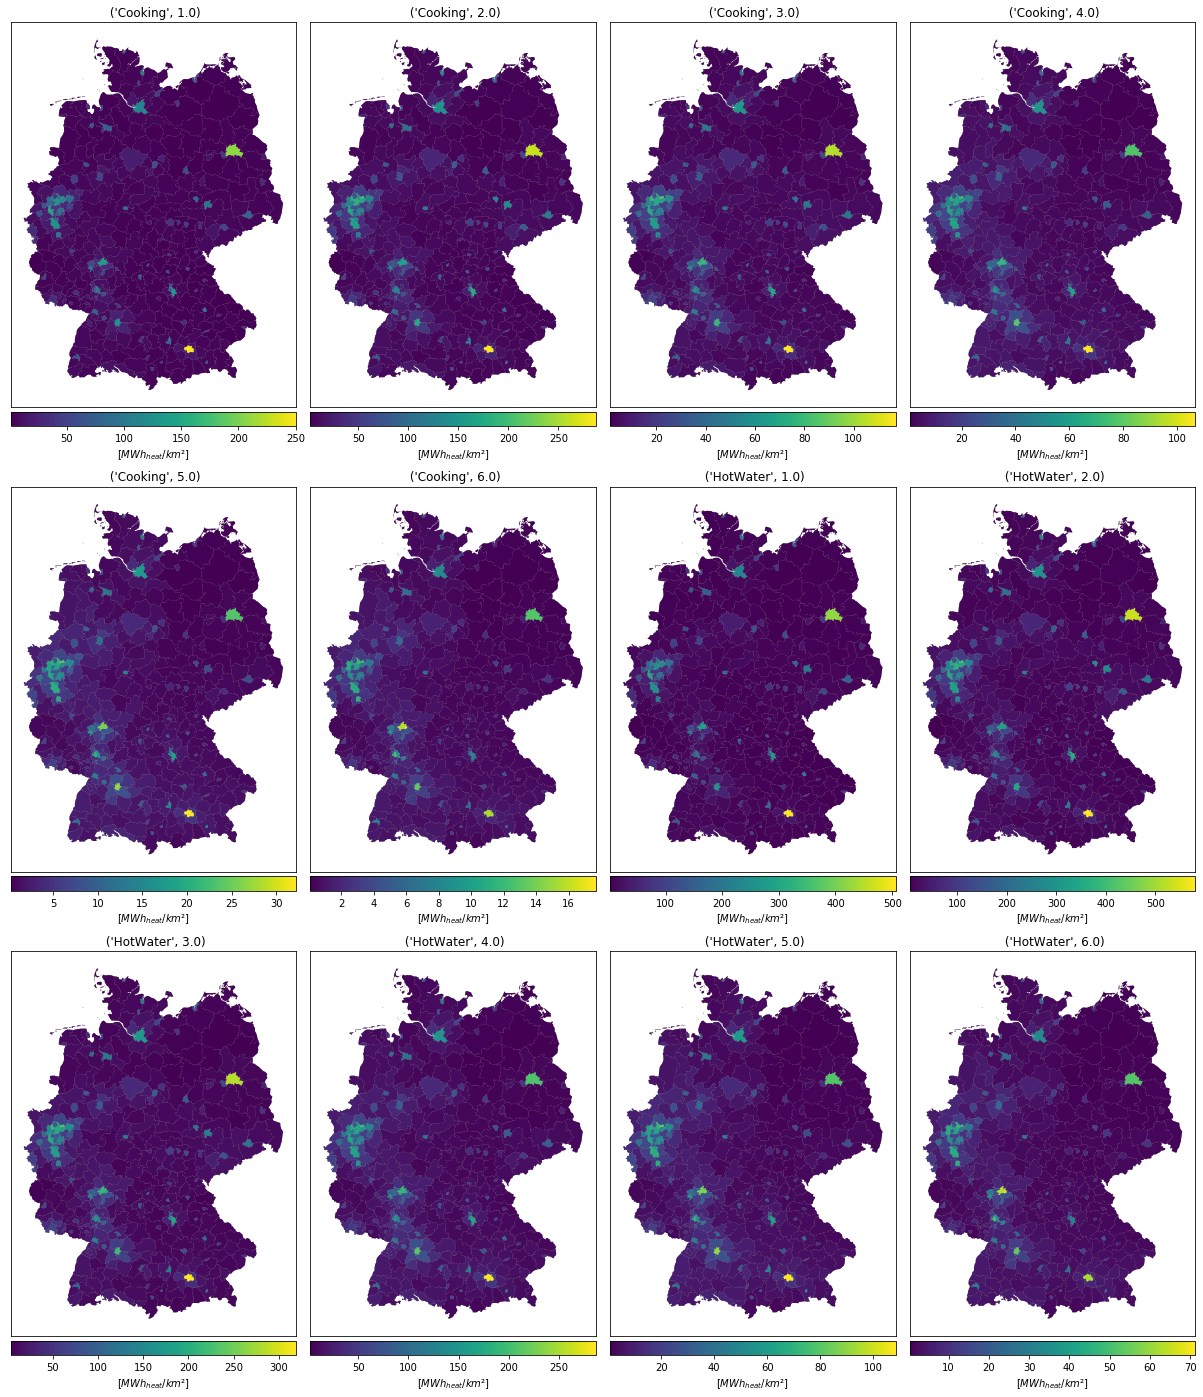

In [13]:
fig, ax = plot.choropleth_map(df_heat, unit='MWh_{heat}', colorbar_each_subplot=True, add_percentages=False)

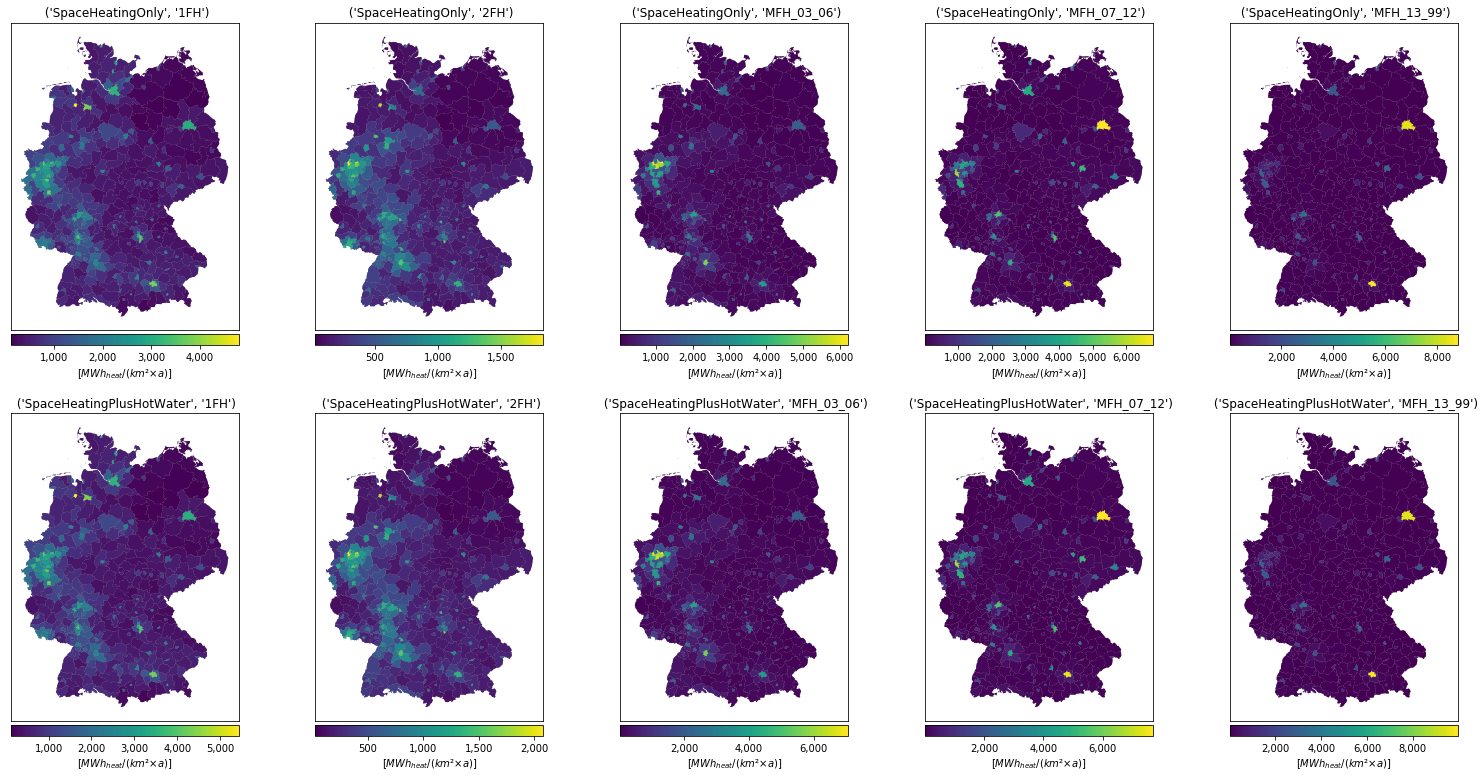

In [14]:
fig, ax = plot.choropleth_map(df_heat_bld, unit='MWh_{heat}/a', colorbar_each_subplot=True, add_percentages=False, figsize=(21, 11))

## Gas Consumption in [MWh/a]

In [15]:
df_gas = spatial.disagg_households_gas()
df_gas.head()

disaggregator.spatial: INFO     Calculating regional gas demands top-down.


,Cooking,HotWater,SpaceHeating
nuts3,,,
DE111,"8,521.563","337,979.141","961,926.648"
DE112,"4,560.001","206,601.209","700,709.681"
DE113,"6,454.651","284,003.849","960,096.499"
DE114,"3,003.337","136,954.763","513,794.773"
DE115,"6,571.148","289,393.738","1,033,030.334"


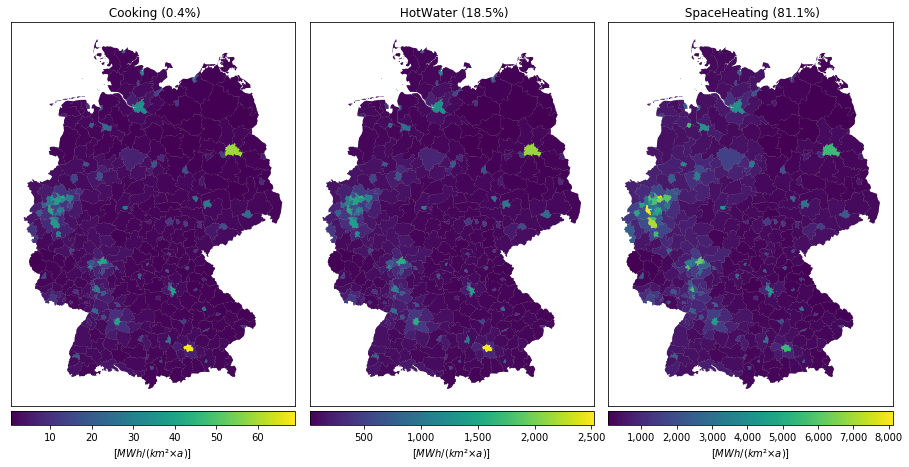

In [16]:
fig, ax = plot.choropleth_map(df_gas, unit='MWh/a', relative=True, colorbar_each_subplot=True)